In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We import all the main important **dependencies** 

In [ ]:
import random, os
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imutils import paths
from sklearn.model_selection import train_test_split
import pickle
import shutil


def tf_seed(seed=0):
  np.random.seed(seed)  # numpy seed
  tf.random.set_seed(seed)  # tensorflow seed
  random.seed(seed)  # random seed
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)
  
def tf2_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.keras.utils.set_random_seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'

                   




tf_seed()

#see https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

# DEFINE NETWORK

The main idea is to classify a **bonafide or attack** human face with a fast **CNN**, setting on the top of the network an **SSD** model, pretrained on a **ResNet**, that can extract faces from images.

The network will have two main convolutional steps, in which we are going to extract deep features from the second phase. It uses in sequence **Conv2d + BatchNormalization** to learn faster, normalizing batch feature maps to avoid **overfitting**. However, this is why is important to set a right batch size and training data to avoid the opposite problem, then underfitting. The BatchNormalization, since this is a shallow network, won't have the so called vanishing gradient problem during the first training epochs.

There are also, at the end of each phase, a Dropout layer. This is because it's important to learn as much details as possible to distinguish a "real or fake" person in front of a camera. So switching off weights during training randomly, will have the consequence to distribute better the learning of important features among all the weights.

## Originary Network

In [ ]:
def LiveNet(input_size):

  chan_dim=-1 #feature map channel

  #first convolutional phase
  input = tf.keras.layers.Input(input_size)
  x = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  #second convolutional phase
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization( axis=chan_dim)(x)
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)

  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  #dense phase
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(64, activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)


  x = tf.keras.layers.Dropout(0.5)(x)  #to avoid overfitting 
  #softmax 
  output = tf.keras.layers.Dense(2, activation = 'softmax')(x)
 
  return tf.keras.models.Model(input, output)

## AttackNet v1.0

This is an improvement of the initial CNN. Since the most important architectures in the state of the art use, to improve efficacy, skip connections (summing and concatenating layers), for example **Yolo**, **U-Net**, **ResNet**, we introduced, for each phase, another Convolutional Layer with more filters at the end. In this case the last two Conv2D won't be normalized soon, but first they're concatenated with the first layer of the phase. In this case, we make the network deeper, but at the same time, we try to improve backpropagation introducing concatenating layers that will add the information of the feature maps of the first layers to the last, thus influencing they're output, and then how the weights will be updated, improving explosion or vanishing gradient issues.

In [ ]:
def LiveNet(input_size):

  chan_dim=-1 #feature map channel
  dropout_seed=2


  #first convolutional phase
  input = tf.keras.layers.Input(input_size)
  y = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(y)
  x = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(x)
  z = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.concatenate([y,z])
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25, seed=dropout_seed)(x)

  #second convolutional phase
  y = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization( axis=chan_dim)(y)
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  z = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.concatenate([y,z])
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25, seed=dropout_seed)(x)

  #dense phase
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(64, activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5, seed=dropout_seed)(x)
  #softmax 
  output = tf.keras.layers.Dense(2, activation = 'softmax')(x)
 
  return tf.keras.models.Model(input, output)

## AttackNet v2.1

This third architecture introduces the use of **LeakyReLU** instead of ReLU. The last layer is now activated by **tanh function**. This was done to try to improve the generalization capability of the network solving the "sparsity" of ReLU, that in several cases can be useful though, and improving in this way the variability of the outputs of the network. Since now we use in the last fully connected layer the tanh activation, LeakyReLU could be useful also for the vanishing gradient problem.

In [ ]:
def LiveNet(input_size):
      chan_dim=-1 #feature map channel

      #first convolutional phase
      input = tf.keras.layers.Input(input_size)
      y = tf.keras.layers.Conv2D(16, 3, padding = 'same')(input)
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
      x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
      x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(x)
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.Conv2D(64, 3, padding = 'same')(x)
      z = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.concatenate([y,z])
      x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
      x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
      x = tf.keras.layers.Dropout(0.25)(x)

      #second convolutional phase
      y = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
      x = tf.keras.layers.BatchNormalization( axis=chan_dim)(x)
      x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
      x = tf.keras.layers.Conv2D(128, 3, padding = 'same')(x)
      z = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.concatenate([y,z])
      x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
      x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
      x = tf.keras.layers.Dropout(0.25)(x)

      #dense phase
      x = tf.keras.layers.Flatten()(x)
      x = tf.keras.layers.Dense(128, activation = 'tanh')(x)

      #x = BatchNormalization()(x)
      x = tf.keras.layers.Dropout(0.5)(x)
      
      #softmax
      output = tf.keras.layers.Dense(2, activation = 'softmax')(x)
      return tf.keras.models.Model(input, output)


## AttackNet v2.2

In [ ]:
def LiveNet(input_size):

  chan_dim=-1 #feature map channel

  #first convolutional phase
  input = tf.keras.layers.Input(input_size)
  y = tf.keras.layers.Conv2D(16, 3, padding = 'same')(input)
  x = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(x)
  z = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  x = tf.keras.layers.add([y,z])
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  #second convolutional phase
  y = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
  x = tf.keras.layers.BatchNormalization( axis=chan_dim)(x)
  x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
  x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
  z = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  x = tf.keras.layers.add([y,z])
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  #dense phase
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation = 'tanh')(x)
  #x = BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  #softmax 
  output = tf.keras.layers.Dense(2, activation = 'softmax')(x)
 
  return tf.keras.models.Model(input, output)

# DATASET

In this case, we built our dataset that consist on **real** images, and **for each** real person, there is one or more **fake** versions.

## Define Root Folders

We define absolute paths that will be used.

We will split dataset in **training**, **validation** subsets. For **testing**, we created 44 extra images for both classes, that have been specifically selected to try to "break down" the results of the network. 
We added those extra images to the validation dataset, but they could be used to make a quick network evaluation. 

In [ ]:
root_folder = "/content/drive/MyDrive/liveness_project/"


protoPath = os.path.join(root_folder, 'face_detector/deploy.prototxt.txt')
modelPath = os.path.join(root_folder,
                         "face_detector/res10_300x300_ssd_iter_140000.caffemodel")


face_confidence = 0.75


path_to_videos = os.path.join(root_folder, 'dataset', 'training', 'videos')
path_to_outputs = os.path.join(root_folder, 'dataset', 'training', 'images')
path_to_test_input = os.path.join(
    root_folder, 'dataset', 'training', 'final_test')


################### INPUT FOLDERS ###################

input_training_real_folder = os.path.join(
    path_to_videos, 'real', 'training')  # input of real training videos
input_training_fake_folder = os.path.join(
    path_to_videos, 'fake', 'training')  # input of real training videos

input_validation_real_folder = os.path.join(
    path_to_videos, 'real', 'validation')  # input for real validation videos
input_validation_fake_folder = os.path.join(
    path_to_videos, 'fake', 'validation')  # input for fake validation videos

input_test_real_folder = os.path.join(
    path_to_test_input, 'real')  # EXTRA (hard) input for real testing videos
input_test_fake_folder = os.path.join(
    path_to_test_input, 'fake')  # EXTRA (hard) input for fake testing videos

################### OUTPUT FOLDERS ###################

# output of detected real faces for training
output_training_real_folder = os.path.join(path_to_outputs, 'real', 'training')
# output of detected fake faces for training
output_training_fake_folder = os.path.join(path_to_outputs, 'fake', 'training')

# output of detected real faces for validation
output_validation_real_folder = os.path.join(
    path_to_outputs, 'real', 'validation')
# output of detected fake faces for validation
output_validation_fake_folder = os.path.join(
    path_to_outputs, 'fake', 'validation')

# output of EXTRA (hard) detected real faces for validation
output_test_real_folder = os.path.join(path_to_outputs, 'test', 'real')
# EXTRA OPTIONAL output of detected fake faces for validation
output_test_fake_folder = os.path.join(path_to_outputs, 'test', 'fake')

# output of EXTRA (hard) detected real faces for validation
save_augmented_images = os.path.join(root_folder, 'dataset/augmented_images/')


save_model_h5 = os.path.join(root_folder, 'first_task_model.h5')
save_labels = os.path.join(root_folder, 'first_task_model_labels')
save_training_metrics_plot = os.path.join(
    root_folder, 'first_task_training_plot.png')

##### if save and reuse a np array for training/validation/testing images #####
output_np_training_array = os.path.join(root_folder, "training.array")

image_for_test = os.path.join(root_folder, 'test.jpg')

# if True will delete all previous extracted faces
delete_training_data_and_reset = False

split_randomly_training_and_validation = False


# will split entire dataset randomly for training and testing
if delete_training_data_and_reset:

    print("we're going to take entire dataset, then we split randomly in training and validation subsets")

    input_training_real_folder += input_validation_real_folder
    input_training_fake_folder += input_validation_fake_folder

    input_validation_real_folder = []
    input_validation_fake_folder = []

    training_directories = [
        input_training_real_folder, input_training_fake_folder]
    output_directories = [output_training_real_folder,
                          output_training_fake_folder]

else:

    print("we're going to use training and validation folders")

    training_directories = [input_training_real_folder, input_validation_real_folder,
                            input_training_fake_folder, input_validation_fake_folder]
    output_directories = [output_training_real_folder, output_validation_real_folder,
                          output_training_fake_folder, output_validation_fake_folder]

#adding testing folders 

training_directories += [input_test_real_folder, input_test_fake_folder]
output_directories += [output_test_real_folder, output_test_fake_folder]

# create directories where to save images if they don't exist
for output_dir in output_directories:
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print("created %s", output_dir)

    else:
        if delete_training_data_and_reset:
            shutil.rmtree(output_dir)
            os.makedirs(output_dir)
            print("recreated %s", output_dir)


# NETWORK PARAMETERS FOR TRAINING

In [ ]:
final_x = 32
final_y = 32

n_channels = 3 #rgb

dim = (final_x, final_y)

epochs=25
batch_size=32
init_learning_rate= 1e-6

#return normalized image
def resize_normalize_image(image, max_value = 255):

    image=cv2.resize(image, dim)
    return  (image)/ np.max(image)


# FACE PROCESSING

## Network to Detect Faces

We define the SSD network that detects face inside an image.

In [ ]:

#read ssd model to detect faces
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath) 


# detect the most probable face, or all of detected face
# return coordinates of bounding box for each face and the face itself as a cv2 object
def detect_save_face(frame, output_path=None, multiple_output=False):

    (h, w) = frame.shape[:2]

    # we preprocess image normalizing each r-g-b channel subtracting the values in the last tuple
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the detections and
    # predictions
    net.setInput(blob)
    detections = net.forward()   #output => (1, 1, 20, [1, 0.9, .... ]   )
    faces = []
    coordinates=[]

    # ensure at least one face was found
    if len(detections) > 0:
        
        max_i=np.argmax(detections[0, 0, :, 2]) #this is the most probable detected face

        #if we want to output the most probable detected face or all the faces
        min_range = 0 if multiple_output==True else max_i 
        max_range = detections.shape[2] if multiple_output==True else max_i + 1

        for i in range(min_range, max_range):

          # we get the model confidence
          confidence = detections[0, 0, i, 2]

          if confidence >= face_confidence:
            # compute the (x, y)-coordinates of the bounding box for
            # the face and extract the face ROI
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # we save coordinates 
            coordinates.append(box.astype("int"))
            face = frame[startY:endY, startX:endX]

            #we save the face
            faces.append(face)
            

            try:
              #if we had defined a mask, we take the face also in that mask
           #   if mask is not None:
            #    face_mask = mask[startY:endY, startX:endX]
             #   cv2.imwrite(output_path_mask, face_mask)
            # write the frame to disk
              
              #we save the image if output_path is defined
              if output_path is not None:
                cv2.imwrite(output_path, face)
             
            except:
              pass

    return faces, coordinates

#frame_mask_output = [mask_genuine_folder, mask_fake_folder]

#return file name given a path
def get_file_name(path):
    base = os.path.basename(path)
    return os.path.splitext(base)[0]

#return file extension given a path
def get_file_type(path): 
    base = os.path.basename(path)
    return os.path.splitext(base)[1] # ex. .png, .jpg



## Extract Faces from Images

We are going to take videos or images from our dataset. For each frame will be detected **one** face, and this one will be saved to the output folders defined before. The code reserves the possibility for the user to define also a mask for each image. In this case, the detected face will be also "cropped" from the mask.

In [ ]:

max_images_per_class=15000 #we want to take a maximum number of images for training since limited hardware resources
max_images_per_video=200 #to avoid to take too many similar frames per video
shuffle_seed=20

#def get_mask_name(mask_suffix, filename):
 # if mask_suffix != "same_name":
  #  return get_file_name(filename) + mask_suffix
  
  #return filename

#def get_mask_file_type(mask_suffix, filename):
 # if mask_suffix != "same_name":
  #  return get_file_type(mask_suffix)
  
  #return get_file_type(filename)

#for each training input directory, search for videos and images
#for each video we extract a limited number of frames per second
#for each image, we detect one face
def take_images(mask=False, mask_suffix="same_name"):
    directory_counter = 0


    file_counter = 0

    for directory in training_directories:

        class_file_counter=0

        files = [file for file in os.listdir(directory)]

        #we shuffle training data since we just take a limited number of images
        random.Random(20).shuffle(files)

        for file in files:

            if class_file_counter > max_images_per_class:
              break

            file_path = os.path.join(directory, file)

            if file.endswith(".mp4"):

                vidcap = cv2.VideoCapture(file_path)

                count = 0

                real_count = 0

                #we take a limited number of frames per second
                while vidcap.isOpened():
                    success, image = vidcap.read()
                    if success and real_count < max_images_per_video and class_file_counter < max_images_per_class:
                        
                        detect_save_face(
                            image, os.path.join(output_directories[directory_counter], "%s.jpg" % ("frame_%d_%d" % (file_counter, count))))
                        count += 5 #we skip 5 frames per time
                        vidcap.set(cv2.CAP_PROP_POS_FRAMES, count)
                       # print(output_directories[directory_counter] + "%s.jpg" % ("frame_%d_%d" % (file_counter, count)))

                        class_file_counter+=1
                        real_count+=1

                        print("save face detected on the frame n. %d of the video n. %d" % (count, file_counter))


                    else:
                        vidcap.release()
                        break

            elif file.endswith('.jpg') or file.endswith('.png') or file.endswith(".jpeg"):
            
                detect_save_face(cv2.imread(file_path), (os.path.join(output_directories[directory_counter], "%s%s" % (
                    "frame_%d" % file_counter, get_file_type(file)))))
                
                print("save face detected on image n. %d" % file_counter)
                
                class_file_counter += 1

            file_counter += 1

        directory_counter += 1


take_images(mask=False) 

# TRAINING SECTION


## Get Training and Validation Data

For each directory where we saved detected faces, we are going to create two arrays: **images** and **labels** (0 for bonafide, 1 for attackers)


In [ ]:

def get_images(directories, mask=False, balance_dataset=True, undersampling=False):

    image_list = []
    label_list = []

    classes = 0

    images_per_class=[]

    tf_seed()

    #for each input directory
    for i in directories:

        list_images = [f for f in os.listdir(i) if os.path.isfile(os.path.join(i, f))]

        images_number = len(list_images)

        print("n %d" % images_number)

        random.Random(20).shuffle(list_images)

        #if we use undersampling
        if undersampling:
          images_number = images_number if ((len(images_per_class) == 0) or (images_number <= images_per_class[-1]))  else images_per_class[-1]
        
        
        # to fill tensors we inizialise them
        X = np.empty((images_number, final_x, final_y, n_channels))

        L = np.empty((images_number))

        ipp = 0

        for im_name in list_images:
            
            im=os.path.join(i, im_name)

            # to get "balanced dataset" using undersampling method
            if (balance_dataset and undersampling) and len(images_per_class)  and ipp == images_per_class[-1]:
                break

            image = cv2.imread(im)
            image=resize_normalize_image(image)

          
            if mask:
              mask_name = os.path.join(
                    i,"mask", get_file_name(im) + "_mask" + get_file_type(im))
              image_mask = cv2.imread(mask_name, 0)
              image_mask = resize_normalize_image(image_mask)
                

            X[ipp, ..., :3] = image # each original image is rgb
            
            if mask:
              X[ipp,...,3] = image_mask # each mask can be n_channels - 3

            L[ipp] = classes  # 0 for real, 1 for fake for binary classification

            ipp += 1
        
        # check if the current class has lower images than the before
        # in this case we undersample the majority class randomly removing elements
        # we will have a balanced dataset: same images for all the classes

        if balance_dataset and undersampling:
            if len(images_per_class) and ipp < images_per_class[-1]:
            
              left_shift = 0

              for i in range(0, len(images_per_class)):

                  diff = images_per_class[i] - ipp

                  for j in range(0, diff):
                      random_index = np.random.randint(left_shift, images_per_class[i] - j)
                      image_list.pop(random_index)
                      label_list.pop(random_index)

                  left_shift += images_per_class[i] - diff

        if undersampling or balance_dataset==False:
              for image in X:
                image_list.append(image)

              for label in L:
                label_list.append(label)
        else:
              image_array=[]
              label_array=[]
            
              for image in X:
                image_array.append(image)

              image_list.append(np.array(image_array, dtype="float"))

             
              for label in L:
                label_array.append(label)

              label_list.append(label_array)

              #[[2k], [1k]]
        
        if undersampling or balance_dataset==False:
            images_per_class.append(ipp)
        else:
            images_per_class.append(images_number)

        classes += 1

    #offline augmentation
    if balance_dataset and undersampling==False:

      
         max=np.max((images_per_class)) #[4k,3k,2k,1k]

         for j in range(0, len(images_per_class)):  #[[4k], [4k], [4k], [4k]]
            if images_per_class[j] < max:
              diff=max - images_per_class[j] #how many images to generate

              image_array=image_list[j]   #[3k]
              label_array=label_list[j]   #[3k]

              new_image_array=[]
             

              #use ImageDataGenerator 
              offline_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                       	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	                       horizontal_flip=True, fill_mode="constant")


              offline_generator=offline_generator.flow(image_array, batch_size=1, seed=20)

              #generate the reamining images respect the majority class, to balance the dataset
              generated_images=0
              while generated_images < diff:
                     
                  for i in range(0,len(offline_generator)):
                        if generated_images == diff:
                          break
                        batch= next(offline_generator)
                        # print(batch.shape)
                        #print(new_image_array.shape)
                        new_image_array.append(batch[0])
                        
                        label_array.append(j)

                      
                        generated_images += 1

     
              image_list[j]=np.append(image_list[j], new_image_array, axis=0)


         # image_list and label_list were of type [[...], [...]] for attack and bonafide classes
         # we need a final array of type [image1,image2,...] for images and [0,1,...] for labels

         new_image_list= np.empty((0, final_x, final_y, n_channels))
         new_label_list=[]


         for class_value_array in image_list:
           new_image_list = np.vstack((new_image_list,class_value_array))

         for class_value_array in label_list:
           new_label_list += class_value_array

         image_list = new_image_list
         label_list = new_label_list

         
        # im_show(new_image_list[2]) # we can show up an image 
      
        
    #create the one-hot encoded vector: [0 1], [1 0]
    le = LabelEncoder()
    labels = le.fit_transform(label_list)
    labels = tf.keras.utils.to_categorical(labels, 2)

    if type(image_list) is np.ndarray:
      return image_list, labels, le

    return  np.array(image_list, dtype="float"), labels, le



read_from_np_array = True



## WE CAN SAVE NUMPY RESULTS AND REUSE THEM LATER ##

if read_from_np_array:
      (train_X, test_X, train_Y, test_Y, final_test_X, final_test_Y) = pickle.loads(open(output_np_training_array, "rb").read())
      le = pickle.loads(open(save_labels, "rb").read())

## WE ARE GOING TO GET THE TRAIN AND VALIDATION DATASETS, AND WE SAVE THE NUMPY ARRAYS ##
else:
      
      train_X, train_Y, label_encoder = get_images([output_training_real_folder, output_training_fake_folder], undersampling = True)

      if delete_training_data_and_reset:
        test_X, test_Y = ([], [])
      else: 
        #will be ignored if we set split_randomly_training_and_validation variable to True
        test_X, test_Y, _ = get_images([output_validation_real_folder, output_validation_fake_folder], undersampling=True)

      final_test_X, final_test_Y, _ = get_images([output_test_real_folder,output_test_fake_folder], balance_dataset = False)
      
     # test_X=np.vstack((test_X,final_test_X))
      #test_Y=np.vstack((test_Y,final_test_Y))


      #save model labels 
      f = open(save_labels, "wb")
      f.write(pickle.dumps(label_encoder))
      f.close()

      #save results
      pickle.dump((train_X, test_X, train_Y, test_Y, final_test_X, final_test_Y), open(output_np_training_array, 'wb'))



#print("max rgb value: %f" % np.max(train_X))

#will split entire dataset in 80% for training and 20% for validation
if split_randomly_training_and_validation:

  #the random seed for splitting 
	split_seed=20

	trainX, testX, trainY, testY = train_test_split(train_X, train_Y,
	test_size=0.2, stratify=train_Y, seed=split_seed)
 
else:
	trainX, testX, trainY, testY = (train_X, test_X, train_Y, test_Y)
 
print("Shape training: ", trainX.shape)
print("Shape validation: ", testX.shape)



## Augmentation Online

In [ ]:
augmentation_online=True



#the random seed for online augmentation
generator_seed=10

 
if augmentation_online:
		#online augmentation of training images
	
		aug_training = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                    zoom_range=0.35,
                    width_shift_range=0.3, height_shift_range=0.3, 
shear_range=0.15,
                    horizontal_flip=True, fill_mode="constant")


		#aug_training = tf.keras.preprocessing.image.ImageDataGenerator()






		#aug_training = tf.keras.preprocessing.image.ImageDataGenerator()


		# output an endless Iterator of batches
		# shuffle images, so the first generated batch is from batch_size random training images

		train_generator=aug_training.flow(trainX, trainY, batch_size=batch_size, shuffle=True, seed=generator_seed)


		# will be equal to np.ceil(len(train(X))/batch_size)
		# notice: if len(trainX) / batch_size is a float value, the last batch will contain less images than batch_size value
		print("lenght training batches ", len(train_generator))
		print("lenght training data ", len(trainX))
		print("lenght validation data ", len(testX))

		# we could use also a validation_generator, without augment images
		# this "trick" could be done for set up a valdation batch size on model.fit().. then at the end of an epoch, each batch will be validated

		#aug_validation=ImageDataGenerator()
		#validation_generator=aug_validation.flow(testX, testY, batch_size=batch_size, shuffle=False, seed=1)

## AUGMENTATION OFFLINE (OPTIONAL)

For each image in the training set, we're going to augment the image itself and we add it to the training. So if we have 2k images for the training, the final length of the dataset will be 4k.

In [ ]:

augmentation_online=False

generator_seed=10
     

if not augmentation_online:


  to_augment=len(trainY)  *2

  #print(to_augment)
  # to fill tensors we inizialise them
  X = np.empty((to_augment, final_x, final_y, n_channels), dtype="float")

  L = np.empty((to_augment), dtype="int")

  #use ImageDataGenerator 
  offline_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
zoom_range=0.15,
width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15,
horizontal_flip=True, fill_mode="constant")



  offline_generator=offline_generator.flow(trainX, trainY, shuffle=True, batch_size=1, seed=generator_seed)

  #for all initial images
  for i in range(0,to_augment):
            batchx, batchy = next(offline_generator)
            X[i] = batchx[0]
            L[i] = np.argmax(batchy[0])
          
  
  labels = le.fit_transform(L)
  labels = tf.keras.utils.to_categorical(labels, 2)

  trainX = np.vstack((trainX, X))
  trainY = np.vstack((trainY, labels))


print("Shape training: ", trainX.shape)
print("Shape validation: ", testX.shape)



Shape training:  (6714, 32, 32, 3)
Shape validation:  (2418, 32, 32, 3)


We can output the generator images organized in batches

Label-0: 0.0
Label-1: 0.0


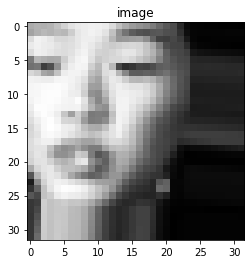

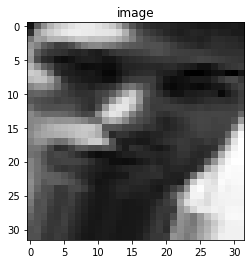

In [ ]:
# E' UN ESPERIMENTO SUL COMPORTAMENTO DI IMAGEDATAGENERATOR SU MODEL.FIT()

# we generate batch_size images, beginning from the first batch
batchx, batchy = next(train_generator)
for i in range(batchx.shape[0]):
    fig, (ax1) = plt.subplots(1) 
    ax1.set_title('image')  
    ax1.imshow(batchx[i][:,:,0], cmap='gray')
    print("Label-%d:"%i, np.argmax(batchy[i]))


train_generator.reset() #once an epoch ends, this function will be called to reset data



# we generate exactly len(trainX) - batch_size images beginning from the first batch, since we have reset the train_generator on the line before
for i in range(0,len(train_generator)):
 break # remove to see all training augmented images for an epoch
 batchx, batchy = next(train_generator)
 for i in range(batchx.shape[0]):
    fig, (ax1) = plt.subplots(1) 
    ax1.set_title('image')  
    ax1.imshow(batchx[i][:,:,0], cmap='gray')
    print("Label-%d:"%i, batchy[i][0])



## **Train the Model**

We train the **model** and we save in a **CustomCallback** instance the average loss and accuracy for each training and validation batch. In this way, we can create a more defined training plot.

In [ ]:

import torch, psutil


class MemoryUsage(tf.keras.callbacks.Callback):

   def __init__(self):
      # setting device on GPU if available, else CPU
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      print('Using device for training:', self.device)
      self.max_RAM=[]
      self.max_GPU=[]

   def get_memory_usage(self):
      gpu_dict = tf.config.experimental.get_memory_info('GPU:0')
      tf.print('\n GPU memory details [current: {} gb, peak: {} gb]'.format(
          float(gpu_dict['current']) / (1024 ** 3), 
          float(gpu_dict['peak']) / (1024 ** 3)))
   
   def get_size(self, byte, suffix="GB"):
    factor = 1024
    
    for unit in ["", "K", "M", "GB", "T", "P"]:
        if byte < factor:
            return f"{byte:.2f} GB"
        byte /= factor

   def on_train_end(self, epoch, logs=None):
      i=np.argmax(self.max_RAM)
      j=np.argmin(self.max_RAM)
      self.get_memory_usage()
      print("MAX RAM USAGE: %s / %s (%s)" % (self.get_size(self.max_RAM[i][0]), self.get_size(self.max_RAM[i][1]), str(self.max_RAM[i][2]) + "%" ))
      


   
   def on_epoch_end(self,epoch,logs=None):
      svmem = psutil.virtual_memory()
      self.max_RAM.append((svmem.active, svmem.total, svmem.percent))
      #self.get_memory_usage()
      
      
      
      


# initialize the optimizer and model
print("[INFO] compiling model...")




#opt = tf.keras.optimizers.SGD(learning_rate=init_learning_rate, momentum = 0.5)
opt = tf.keras.optimizers.Adam(learning_rate=init_learning_rate)
#opt = tf.keras.optimizers.Adam(learning_rate=init_learning_rate)

#opt = tf.keras.optimizers.SGD(learning_rate=init_learning_rate, momentum = 0.5)
#opt = tf.keras.optimizers.Adam(learning_rate=init_learning_rate, decay=init_learning_rate/epochs)


#opt = tf.keras.optimizers.SGD(learning_rate=init_learning_rate, momentum = 0.99)
tf_seed()
model = LiveNet((final_y,final_x,n_channels))

callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
memory_usage = MemoryUsage()


model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])  # same of binary_crossentropy in this case



import time
start_time = time.time()

#validation batch_size is equal to batch_size in this case (32)
#check https://github.com/keras-team/keras/blob/v2.9.0/keras/engine/training.py#L1099-L1472
if augmentation_online:
    H=model.fit(
      train_generator, 
      validation_data = (testX, testY), 
      callbacks = [memory_usage, callback_early_stopping],
      epochs= epochs)
else:
   
   H=model.fit(
      trainX, trainY, 
      batch_size = batch_size,
      shuffle=True,
      validation_data = (testX, testY), 
      callbacks = [memory_usage, callback_early_stopping],
      epochs= epochs)

print("TRAINING TIME")
print("--- %s seconds ---" % (time.time() - start_time))

import matplotlib.pyplot as plt

#print((history.epoch_batch_train_acc[0])) #show first epoch batches averaged values

print("[INFO] serializing network to '{}'...".format(save_model_h5))
model.save(save_model_h5, save_format="h5")


if not read_from_np_array:
   #save model labels 
      f = open(save_labels, "wb")
      f.write(pickle.dumps(label_encoder))
      f.close()


plt.style.use("ggplot")
plt.figure()
fig=plt.figure(figsize=(12,7))



new_epochs=len(H.history['loss'])
plt.plot(np.arange(0, new_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, new_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, new_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, new_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


plt.savefig(save_training_metrics_plot)


# notice accuracy at the end of each epoch is the mean all over the batches, the same if we have more than 1 validation batch

#https://keras.io/guides/training_with_built_in_methods/
#https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss
#https://stackoverflow.com/questions/55097362/different-accuracy-by-fit-and-evaluate-in-keras-with-the-same-dataset

# the below code can give never seen images at each validation_step; more in general we divide validation dataset in batches
# see https://stackoverflow.com/questions/56991909/how-is-the-keras-accuracy-showed-in-progress-bar-calculated-from-which-inputs-i


#model.fit(train_generator,
 # steps_per_epoch=len(train_generator),
  #validation_data = validation_generator,
	#epochs=3)

## Evaluation

In [ ]:
#confusion matrix


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools
from itertools import cycle
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

model = tf.keras.models.load_model(save_model_h5)

y_score = model.predict(testX)

y_pred = np.argmax(y_score, axis = 1)
y_test_ = np.argmax(testY, axis = 1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    print(cm)
  
    def precision(index):
      return round(cm[index][index] / cm[:, index].sum(),2)
    
    def recall(index):
      return round(cm[index][index] /cm[index].sum(),2)
    
    def F1_score(index):
      p=precision(index)
      r=recall(index)
      return round((2 * p * r)/(p + r),2)
    
    plt.figure(figsize=(6, 6), dpi=80)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
   

    #### CREATE THE PRECISION / RECALL / F1_SCORE TABLE ####

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fig, ax1 = plt.subplots(figsize=(10, 2 + 3 / 2.5))
    
    col_labels=["Bonafide", "Attacker"]
    row_labels=['Precision','Recall','F1 Score']
    row_func=[precision,recall,F1_score]
    table_vals=[]  

    row_colors = np.full(len(row_labels), 'linen')
    col_colors = np.full(len(col_labels), 'lavender')

    
    for i in range(0, len(row_labels)):

      row=[]

      for j in range(0, len(col_labels)):
         row.append(row_func[i](j))

      table_vals.append(row)
    

    # the rectangle is where I want to place the table
    table = plt.table(cellText=table_vals,
                  cellLoc='center',
                  rowColours=row_colors,
                  rowLabels=row_labels,
                  rowLoc='center',
                  colColours=col_colors,
                  colLabels=col_labels,
                  loc='center')
    table.scale(1, 2)
    ax1.axis('off')

class_names = ["Bonafide", "Attacker"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_, y_pred)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')


# we're using SoftMax
sigmoid=False

# if you use sigmoid as output, you can print one ROC Curve
if sigmoid:
    #ROC CURVE

    fpr, tpr, _ =  roc_curve(test_Y, y_score)
    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=(5, 5), dpi=80)
    lw = 2

    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


## Random Testing

In this section we can test beginning from an image or using our webcam (to take one shot) for live detection

In [ ]:
import time
model = tf.keras.models.load_model(save_model_h5)
le = pickle.loads(open(save_labels, "rb").read())

def extract_and_predict_faces(image):

    def translate(k):
      if k == 0:
        return "Real"
      return "Fake"

    extracted_test_faces, coordinates_faces = detect_save_face(
    image, multiple_output=False)

    for i in range(0, len(extracted_test_faces)):

        face = extracted_test_faces[i]
        (startX, startY, endX, endY) = coordinates_faces[i]

        if face is not None:

            #print(face)
            face = resize_normalize_image(face)
            face = face.astype("float")
            face = tf.keras.utils.img_to_array(face)
            face = np.expand_dims(face, axis=0)
            start_time = time.time()

            preds = model.predict(face)[0]

            print("--- inference in seconds : %f ---" % (time.time() - start_time))


            print(preds)
            j = np.argmax(preds)
            label = le.classes_[j]
            
            

            # draw the label and bounding box on the frame
            label = "{}: {:.4f}".format(translate(label), preds[j])
            print(label)

           
            cv2.putText(image, label, (startX - 150, startY + 55),
                        cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 255), 5)
            cv2.rectangle(image, (startX, startY), (endX, endY),
                      (0, 0, 255), 20)

def im_show(image, output=None):
   fig = plt.figure(figsize=(10, 10)) # set the height and width in inches
   plt.imshow(image, cmap="Greys")
   plt.axis("off")
   plt.show()

   if output is not None:
     cv2.imwrite(output, image)


In [ ]:

image_for_test = os.path.join(root_folder,'test3.jpg') 

face_confidence=0.16


#we use an image we choose
tested_image = cv2.imread(image_for_test)

extract_and_predict_faces(tested_image)

im_show(tested_image, "test5.jpg")


In the code below we access to the webcam to take a frame and predict it

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  
  
  # Show the image which was just taken.
  image=cv2.imread(filename)
 
  extract_and_predict_faces(image)

  im_show(image)

  cv2.imwrite("photo.png", image)

  print('Saved to {}'.format("photo.png"))

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))